In [15]:
%%capture
!python3 -m pip3 install -r ../requirements.txt

---
## Imports

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torcheval import metrics
import matplotlib.pyplot as plt
import PIL

---
# Data Preproc

In [2]:
train_data = datasets.MNIST(root='../data', download=True, train=True, 
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root='../data', download=True, train=False, 
                            transform=transforms.ToTensor())
# conv 3d format (n_samples, n_channels, dim_x, dim_y)
train_x = (train_data.data.type(torch.float32)/255.0).view(-1, 1, 28, 28) # minmax
test_x = (test_data.data.type(torch.float32)/255.0).view(-1, 1, 28, 28) # minmax

train_y = torch.nn.functional.one_hot(train_data.targets).type(torch.float32)
test_y = test_data.targets # no one hot
print(train_data, test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


---
## Model Definition

In [3]:
n_classes = 10  
model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Flatten(start_dim=1),
        nn.Linear(32*16, n_classes),
)

model(train_x[0:1]).shape
print(model)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=512, out_features=10, bias=True)
)


---
## Evaluation (before training)

In [7]:
def evaluate(current_model):
    test_pred_y = torch.nn.functional.softmax(current_model(test_x), dim=1)
    print(test_pred_y.shape)
    test_pred_y = torch.argmax(test_pred_y, dim=1)
    print(test_pred_y.shape)
    #
    acc = metrics.functional.multiclass_accuracy(test_pred_y, test_y).numpy()
    prec = metrics.functional.multiclass_precision(test_pred_y, test_y).numpy()
    rec = metrics.functional.multiclass_recall(test_pred_y, test_y).numpy()
    print(f"Accuracy: {acc*100:.2f}%\nPrecision: {prec*100:.2f}%\nRecall: {rec*100:.2f}%")

evaluate(model)

torch.Size([10000, 10])
torch.Size([10000])
Accuracy: 10.62%
Precision: 10.62%
Recall: 10.62%


--- 
## Model Train

Epoch 0 loss: 0.000370
Epoch 1 loss: 0.000074
Epoch 2 loss: 0.000049
Epoch 3 loss: 0.000038
Epoch 4 loss: 0.000032
Epoch 5 loss: 0.000028
Epoch 6 loss: 0.000024
Epoch 7 loss: 0.000020
Epoch 8 loss: 0.000019
Epoch 9 loss: 0.000019
Epoch 10 loss: 0.000021
Epoch 11 loss: 0.000018
Epoch 12 loss: 0.000013
Epoch 13 loss: 0.000010
Epoch 14 loss: 0.000010
Epoch 15 loss: 0.000010
Epoch 16 loss: 0.000010
Epoch 17 loss: 0.000010
Epoch 18 loss: 0.000009
Epoch 19 loss: 0.000009
Epoch 20 loss: 0.000007
Epoch 21 loss: 0.000007
Epoch 22 loss: 0.000005
Epoch 23 loss: 0.000005
Epoch 24 loss: 0.000005
Epoch 25 loss: 0.000009
Epoch 26 loss: 0.000009
Epoch 27 loss: 0.000009
Epoch 28 loss: 0.000009
Epoch 29 loss: 0.000007
Epoch 30 loss: 0.000005
Epoch 31 loss: 0.000004


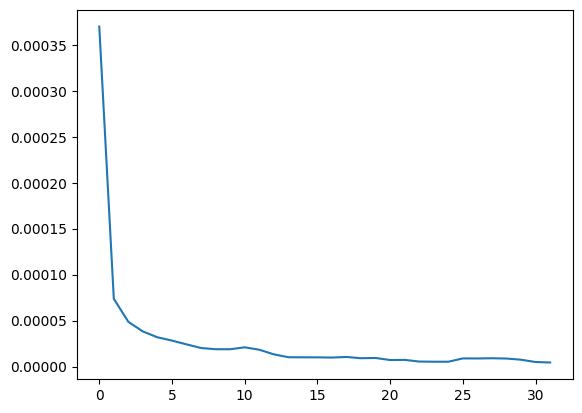

In [4]:
epochs = 32
batch_size = 1024
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

for epoch in range(epochs):
    loss_sum = 0
    for i in range(0, len(train_x), batch_size):
        batch_x = train_x[i:i + batch_size]
        batch_y = train_y[i:i + batch_size]
        optimizer.zero_grad()
        # forward pass
        y_pred = model(batch_x)
        # loss computation
        loss = torch.nn.functional.cross_entropy(y_pred, batch_y)
        loss.backward() # compute gradients
        loss_sum += loss.data
        # weight update
        optimizer.step()
    cost = loss_sum/len(train_x)
    losses.append(cost)
    
    print(f"Epoch {epoch} loss: {cost:.6f}")
    
plt.plot(losses)

---
## Evaluation (After training)

In [15]:
evaluate(model)

torch.Size([10000, 10])
torch.Size([10000])
Accuracy: 99.02%
Precision: 99.02%
Recall: 99.02%


---
## Model Save and Load

In [13]:
torch.save(model, './model_cnn_mnist.torch')

In [14]:
model = torch.load('./model_cnn_mnist.torch')
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=512, out_features=10, bias=True)
)

---
## Model Predict

In [10]:
path = './test_e.jpg'
img = PIL.Image.open(path).convert('L')
img = PIL.ImageOps.isnvert(img)
img_width = 28
img = transforms.Resize((img_width, img_width))(img)
img = transforms.ToTensor()(img)
img_tensor = img.view(1,1,img_width,img_width)
# print(img_tensor.mean())
# # Atribua 1 aos elementos diferentes de zero
# img_tensor[ (img_tensor != 0)] = 1
# print(img_tensor.mean())


with torch.no_grad():
    y = model(img_tensor)
    y = torch.nn.functional.softmax(y, dim=1)
print('Resultado:', torch.argmax(y))

Resultado: tensor(8)
